In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
mnist =tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

x_train, x_test = x_train/127.5 - 1, x_test/127.5 - 1

nb_features = np.prod(x_train.shape[1:])

x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### Task 1. Data visualisation (10 points)

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train)

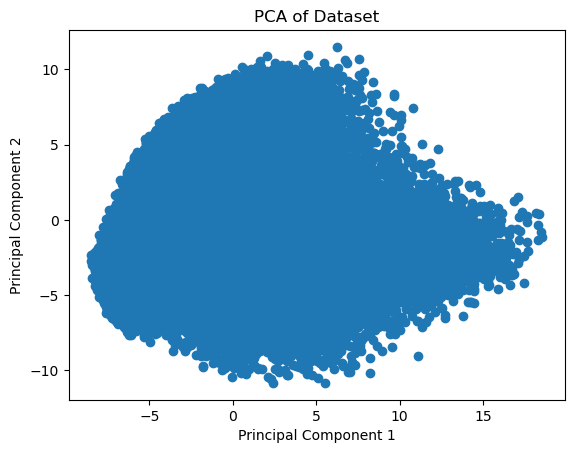

Explained variance ratio: [0.09704664 0.07095924]


In [19]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("PCA of Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Step 4: Check explained variance ratio (how much variance is captured by each component)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

* Why is PCA a good option to visualise data?
* Add plots to your report and discuss your observations.
* Which classes can be linearly separated?


### Task 2. Perceptrons (10 points)

In [26]:
cond = (y_train==0) + (y_train==1)
binary_x_train = x_train[cond, :]
binary_y_train = y_train[cond]
binary_y_train[b]